In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, figure, show, xlabel, ylabel, legend, subplot, semilogx, grid, loglog, title
from sklearn import model_selection, tree
%matplotlib inline
import sklearn.linear_model as lm
from toolbox_02450 import rlr_validate



In [82]:
(glass_dataset := pd.read_csv('data/glass.csv', header = 0))

,ID,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
209,210,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,211,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,212,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,213,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


In [83]:
labels = list(glass_dataset.columns)
X = np.array(glass_dataset[labels[2:-2]])
y = np.array(glass_dataset[labels[1]])
attributeNames = labels[2:-2]
# print(X)
# print(Y)
regularized_X = (X-np.mean(X,0))/np.std(X,0)
N, M = X.shape

# Kinda normal fordelt /TODO
# plt.hist(X[:,3],bins = 25)
# np.mean(X,0)
# np.std(X,0)
X = regularized_X


# Regression

In [84]:
# Regression setup
test_proportion = 0.2
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,Y,test_size=test_proportion)

model = lm.LinearRegression(fit_intercept=True)
model = model.fit(X_train,y_train)

# Compute model output:
y_est = model.predict(X_test)



In [85]:
# L1 loss
print(f'L1 loss: {(l1_loss := np.sum((y_est-y_test)))}')
# L2 loss
print(f'L2 loss: {(l2_loss := np.sum((y_est-y_test)**2))}')



L1 loss: 0.0033412534535695038
L2 loss: 5.805741786919131e-05


In [86]:
K = 10
CV = model_selection.KFold(K, shuffle=True)

In [87]:
lambdas = np.power(10.,range(-5,9))

In [88]:
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))

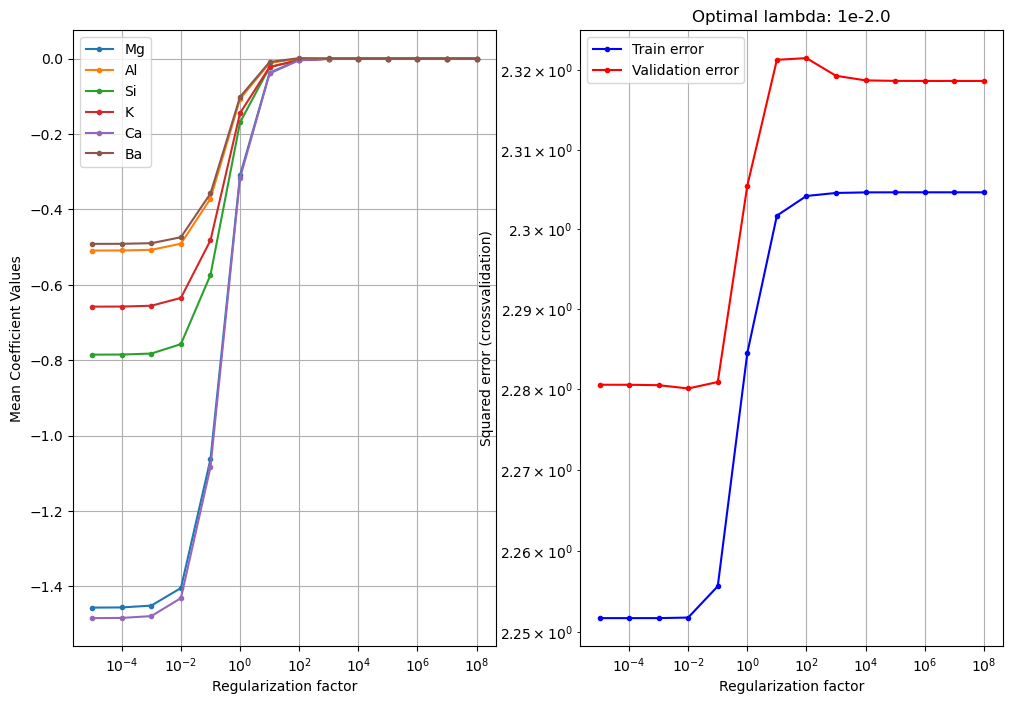

Linear regression without feature selection:
- Training error: 2.287509618671833
- Test error:     2.253933943610746
- R^2 train:     -249309.42922048885
- R^2 test:     -254931.3483677931

Regularized linear regression:
- Training error: 2.2938231057120433
- Test error:     2.269986054923352
- R^2 train:     -249997.52169932472
- R^2 test:     -256746.93060558854

Weights in last fold:
             Na           -0.82
             Mg           -1.51
             Al           -0.52
             Si            -0.8
              K           -0.71
             Ca           -1.51
             Ba           -0.49


In [91]:
k = 0
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10    
    
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    #m = lm.LinearRegression().fit(X_train, y_train)
    #Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    #Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K-1:
        figure(k, figsize=(12,8))
        subplot(1,2,1)
        semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
        xlabel('Regularization factor')
        ylabel('Mean Coefficient Values')
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner 
        # plot, since there are many attributes
        legend(attributeNames[1:], loc='best')
        
        subplot(1,2,2)
        title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
        loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        xlabel('Regularization factor')
        ylabel('Squared error (crossvalidation)')
        legend(['Train error','Validation error'])
        grid()
    
    # To inspect the used indices, use these print statements
    #print('Cross validation fold {0}/{1}:'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}\n'.format(test_index))

    k+=1

show()
# Display results
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

print('Weights in last fold:')
for m in range(M):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,-1],2)))
